In [7]:
import itertools
import sklearn.cluster
import time
import math
from tqdm import tqdm
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import *
import warnings

warnings.filterwarnings('ignore')

UNUSED_DATA = [i for j in (range(5,7), range(8,11), range(11,26), range(26,39)) for i in j]

def create_num_map(names):
    return {name:i+1 for i,name in enumerate(names)}

PARTY_MAP = create_num_map(
                ["Republican",
                 "Democratic",
                 "Libertarian",
                 "American Independent",
                 "Non-Partisan",
                 "Green",
                 "Natural Law",
                 "Other"])
ETHNICITY_MAP = create_num_map(
                ["European",
                 "African-American",
                 "Asian",
                 "Hispanic",
                 "Other"])
MARITALSTAT_MAP = create_num_map(
                ["Married",
                 "Non-Traditional"])
EDUCATION_MAP = create_num_map(
                ["Less than HS Diploma - Likely",
                 "Less than HS Diploma - Ex Like",
                 "HS Diploma - Likely",
                 "HS Diploma - Extremely Likely",
                 "Some College - Likely",
                 "Some College -Extremely Likely",
                 "Bach Degree - Likely",
                 "Bach Degree - Extremely Likely",
                 "Some College -Extremely Likely",
                 "Grad Degree - Likely",
                 "Grad Degree - Extremely Likely",
                 "Vocational Technical Degree - Extremely Likely"])

def timer():
    elapsed_time = (time.time() - start)
    return " {0:.2f}".format(elapsed_time) + " seconds" if elapsed_time <= 120 else " {0:.2f}".format(elapsed_time/60) + " minutes"

def make_numerical(data_array, name_value_map):
    return data_array.map(lambda x : 0 if type(x) is float and math.isnan(x) else name_value_map[x])

def clean(data):
    # This function converts data into numerical values for clustering reasons
    general_elect_hist = data[data.columns[range(12,26,2)]]
    data = data.drop(data.columns[UNUSED_DATA], axis=1)
    
    data.age = data.age.map(lambda x : -1 if math.isnan(x) else x)
    data.party = make_numerical(data.party, PARTY_MAP)
    data.ethnicity = make_numerical(data.ethnicity, ETHNICITY_MAP)
    data.maritalstatus = make_numerical(data.maritalstatus, MARITALSTAT_MAP)
    data.education = make_numerical(data.education, EDUCATION_MAP)
    
    general_elect_prob = general_elect_hist.mean(axis=1).to_frame()
    general_elect_prob.columns = ['general_elect_prob']
    data = pandas.concat([data, general_elect_prob], axis=1)
    
    return data

def create_landmarks(data, M):
    # Create clusters using sklearn.
    s_data = data.drop('optimus_id', 1)
    
    unlikely_voter = s_data[s_data.general_elect_prob == 0]
    landmarks = []
    random_unlikely_voter = unlikely_voter.iloc[[np.random.randint(0,unlikely_voter.shape[0])]]
    landmarks.append(random_unlikely_voter)
    
    print ("Finished filtering for unlikely voters", timer())
    
    mat = s_data.as_matrix()
    print ("Starting clusters")
    km = sklearn.cluster.KMeans(n_clusters=M)
    km.fit(mat)
    print ("Created clusters ", timer())
    labels = km.labels_
    results = pandas.DataFrame([s_data.index,labels]).T
    
    print ("Starting Landmarks ", timer())
    for i in range(0,M):
        cluster = s_data[results[1] == i]
        random_voter = cluster.iloc[[np.random.randint(0,cluster.shape[0])]]
        random_voter.general_elect_prob = np.mean(cluster['general_elect_prob'])
        landmarks.append(random_voter)
    landmarks = pandas.concat(landmarks)
    print ("Created Landmarks ", timer())
    return landmarks

def plot_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    if normalize:
        cm = cm / cm[0][0]

    thresh = ((cm.max() - cm.min()) / 2) + cm.min()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Landmark i')
    plt.xlabel('Landmark j')

def kernel(weight, xi, xj):
    return weight * np.equal(xi, xj)

def composite_kernel(df1, df2):
    return (kernel(1, *np.meshgrid(df1.general_elect_prob, df2.general_elect_prob))
            + (kernel(3, *np.meshgrid(df1.education, df2.education))
            + kernel(2, *np.meshgrid(df1.maritalstatus, df2.maritalstatus))
            + kernel(1, *np.meshgrid(df1.ethnicity, df2.ethnicity))
            + kernel(1, *np.meshgrid(df1.party, df2.party))
            + kernel(3, *np.meshgrid(df1.age, df2.age))))

Started
Finished importing and cleaning data  0.61 seconds
Finished filtering for unlikely voters  0.62 seconds
Starting clusters
Created clusters   5.00 minutes
Starting Landmarks   5.09 minutes
Created Landmarks   6.00 minutes
Past y_1  6.00 minutes
Past k_mm  6.00 minutes
Past k_mn  6.17 minutes
Past k_nm  6.17 minutes
Past k_tm  6.34 minutes
Past mu_t  40.22 minutes


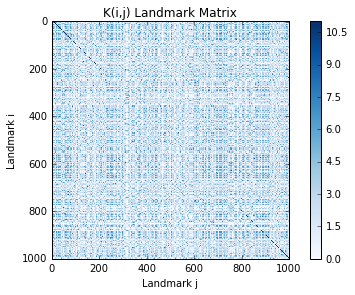

Printed matrix  61.20 minutes
Finished in  61.38 minutes


In [8]:
# this is our training data
np.set_printoptions(precision=2)
start = time.time()
print ("Started")

raw_voter_data = pandas.read_csv( 'voterfile.csv' )
voter_data = clean(raw_voter_data)

print ("Finished importing and cleaning data", timer())

M = 1000
landmarks = create_landmarks(voter_data, M)

y_1 = np.asarray(voter_data.general_elect_prob).T
print ("Past y_1", timer())
k_mm = composite_kernel(landmarks, landmarks)
print ("Past k_mm", timer())
k_nm = composite_kernel(landmarks, voter_data)
print ("Past k_mn", timer())
k_mn = k_nm.T
print ("Past k_nm", timer())
k_tm = composite_kernel(landmarks, voter_data)
print ("Past k_tm", timer())

mu_t = np.dot(k_tm, np.dot(np.linalg.pinv(np.dot(k_mn,k_nm)+k_mm), np.dot(k_mn,y_1)))

print ("Past mu_t", timer())

plt.figure()
plot_matrix(np.array(k_mm), classes=range(1,len(k_mm)+1), normalize=True,
                      title='K(i,j) Landmark Matrix')
plt.show()

print ("Printed matrix", timer())

with open('voter_predictions.csv','w') as out_file:
    print('"optimus_id","age","party","vote","vote_prob"', file=out_file)
    for id in range( 0, mu_t.shape[0] ):
        print('{},{},{},{},{:0.2f}'.format(voter_data.optimus_id[id], 
                                           round(voter_data.age[id]), 
                                           raw_voter_data.party[id],
                                           round(mu_t[id],0), 
                                           max(0,mu_t[id])), file=out_file)
    out_file.close()

voting_turnout = DataFrame(Series(mu_t), columns=['voting_prob'], dtype=np.float64)
raw_voter_data = pandas.concat([raw_voter_data, voting_turnout], axis=1, join_axes=[voting_turnout.index])
raw_voter_data = raw_voter_data[raw_voter_data.voting_prob >= .5].reset_index()

with open('probable_voter_stats.csv','w') as out_file:
    print('"optimus_id", "age", "party", "ethnicity", "maritalstatus", "income", "cd", "dma"', file=out_file)
    for id in range( 0, raw_voter_data.shape[0] ):
        print('{},{},{},{},{},{},{},{}'.format(raw_voter_data.optimus_id[id], 
                                           round(raw_voter_data.age[id]), 
                                           raw_voter_data.party[id], 
                                           raw_voter_data.ethnicity[id], 
                                           raw_voter_data.maritalstatus[id], 
                                           raw_voter_data.income[id], 
                                           raw_voter_data.cd[id], 
                                           raw_voter_data.dma[id]), file=out_file)
    out_file.close()

print ("Finished in", timer())

In [11]:
actual = pandas.read_csv( 'voterfile.csv' )['vh12g']
predicted = np.round(mu_t)

print("RMSE for predictions: ", np.mean(predicted - actual))

bad_prediction = np.round([np.random.sample() for x in range(50000)])

print("RMSE for complete randomness: ", np.mean(bad_prediction - actual))

RMSE for predictions:  0.19482
RMSE for complete randomness:  0.23738
